## Extremum Seeking Optimization

In this example we demonstrate extremum seeking optimization. The optimum of the test evaluate function would drift around a center point and we would be trying to follow the trend by applying extremum seeking technique.

In [1]:
# If you encounter the "Initializing libomp.dylib, but found libomp.dylib already initialized." error
# Please run this cell

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import numpy as np
from xopt.generators.es.extremumseeking import ExtremumSeekingGenerator
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
from xopt import Xopt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

### Extremum seeking test problem

This test problem is a 10-D quadratic function, with its optimum drifting around the initial position. We also add some noise to make the problem more realistic.

In [3]:
np.random.seed(42)  # set deterministic run

nES = 10
ES_steps = 5000  # maximum number of evaluations

# This global dict is used as a counter to emulate drifting
states = {
    'count': 0
}

noise = 0.1 * np.random.randn(ES_steps)

# This is the unknown optimal point
p_opt = 1.5 * (2 * np.random.rand(nES) - 1)

# Various frequencies for unknown points
w_opt = 0.25 + 2 * np.random.rand(nES)

def f_ES_minimize(input_dict):
    p = []
    for i in range(10):
        p.append(input_dict[f'p{i}'])
    p = np.array(p)
    
    # Vary the optimal point with time
    p_opt_i = np.zeros(nES)
    i = states['count']
    
    outcome_dict = {}
    for n in np.arange(nES):
        p_opt_i[n] = p_opt[n] * (1 + np.sin(2 * np.pi * w_opt[n] * i / 2000))
    # This simple cost will be distance from the optimal point
    f_val = np.sum((p - p_opt_i) ** 2) + noise[i]
    
    states['count'] += 1
    outcome_dict = {'f': f_val, 'p_opt': p_opt_i}
    
    return outcome_dict

### Run ES on the test problem (YAML method)

In [4]:
YAML = """
xopt:
    max_evaluations: 5000
generator:
    name: extremum_seeking
    k: 2.0
    oscillation_size: 0.1
    decay_rate: 1.0
evaluator:
    function: __main__.f_ES_minimize
vocs:
    variables:
        p0: [-2, 2]
        p1: [-2, 2]
        p2: [-2, 2]
        p3: [-2, 2]
        p4: [-2, 2]
        p5: [-2, 2]
        p6: [-2, 2]
        p7: [-2, 2]
        p8: [-2, 2]
        p9: [-2, 2]
    objectives:
        f: MINIMIZE
"""

X = Xopt(YAML)
X


            Xopt
________________________________
Version: 1.1.2+57.g15fa7b8
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: null, max_evaluations: 5000}
generator: {name: extremum_seeking, k: 2.0, oscillation_size: 0.1, decay_rate: 1.0}
evaluator:
  function: __main__.f_ES_minimize
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    p0: [-2.0, 2.0]
    p1: [-2.0, 2.0]
    p2: [-2.0, 2.0]
    p3: [-2.0, 2.0]
    p4: [-2.0, 2.0]
    p5: [-2.0, 2.0]
    p6: [-2.0, 2.0]
    p7: [-2.0, 2.0]
    p8: [-2.0, 2.0]
    p9: [-2.0, 2.0]
  constraints: {}
  objectives: {f: MINIMIZE}
  constants: {}
  linked_variables: {}


In [5]:
# Reset global counter to guarantee deterministic optimization
states['count'] = 0

X.run()

Now you can go directly to the [Visualization](#Visualization) section and check out the results.

### Run ES on the test problem (API method)

#### VOCS

We'll set the bounds for all the variables pi to [-2, 2].

In [9]:
variables = {}
for i in range(nES):
    variables[f'p{i}'] = [-2, 2]

vocs = VOCS(
    variables=variables,
    objectives={'f': 'MINIMIZE'},
)

In [10]:
vocs

VOCS(variables={'p0': [-2.0, 2.0], 'p1': [-2.0, 2.0], 'p2': [-2.0, 2.0], 'p3': [-2.0, 2.0], 'p4': [-2.0, 2.0], 'p5': [-2.0, 2.0], 'p6': [-2.0, 2.0], 'p7': [-2.0, 2.0], 'p8': [-2.0, 2.0], 'p9': [-2.0, 2.0]}, constraints={}, objectives={'f': 'MINIMIZE'}, constants={}, linked_variables={})

#### Evaluator

In [11]:
evaluator = Evaluator(function=f_ES_minimize)

#### Generator

In [12]:
generator = ExtremumSeekingGenerator(vocs)

In [13]:
generator.options

ExtremumSeekingOptions(k=2.0, oscillation_size=0.1, decay_rate=1.0)

Note that ES has 3 hyper-parameters: `k`, `oscillation_size`, and `decay_rate`.

- `k`: ES feedback gain (set `k < 0` for maximization instead of minimization)
- `oscillation_size`: ES dithering size
- `decay_rate`: This value is optional, it causes the oscillation sizes to naturally decay. If you want the parameters to persistently oscillate without decay, set `decay_rate = 1.0`

#### Run the optimization

In [14]:
X = Xopt(vocs=vocs, evaluator=evaluator, generator=generator)

In [15]:
X.options.max_evaluations = ES_steps

In [16]:
# Reset global counter to guarantee deterministic optimization
states['count'] = 0

for i in tqdm(range(ES_steps)):
    X.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

### Visualization

In [6]:
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


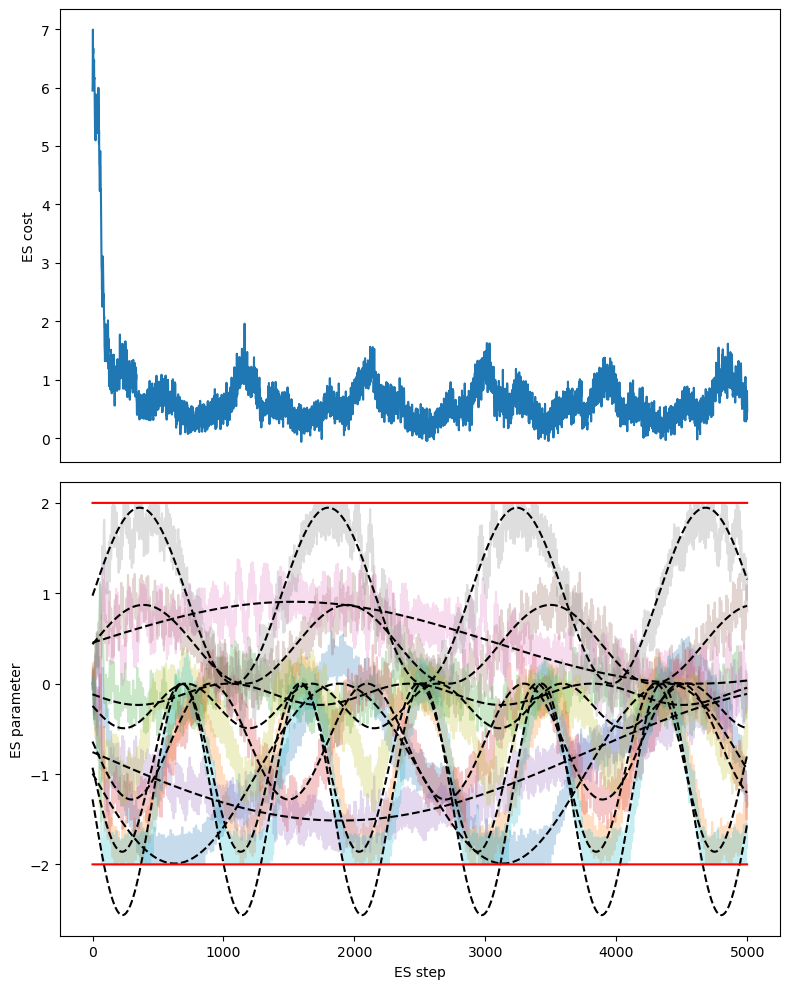

In [17]:
# Plot all results
plt.figure(1,figsize=(8,10))

plt.subplot(2,1,1)
plt.plot(X.data['f'])
plt.ylabel('ES cost')
plt.xticks([])


plt.subplot(2,1,2)
plt.plot(X.data[[f'p{i}' for i in range(10)]],alpha=0.25)
_p_opt = np.vstack(X.data['p_opt'].values).astype(np.float)  # do not use p_opt as var name!
plt.plot(_p_opt, 'k--')
plt.plot(2+np.zeros(ES_steps),'r')
plt.plot(-2+np.zeros(ES_steps),'r')
plt.legend(frameon=False)
plt.ylabel('ES parameter')
plt.xlabel('ES step')

plt.tight_layout()

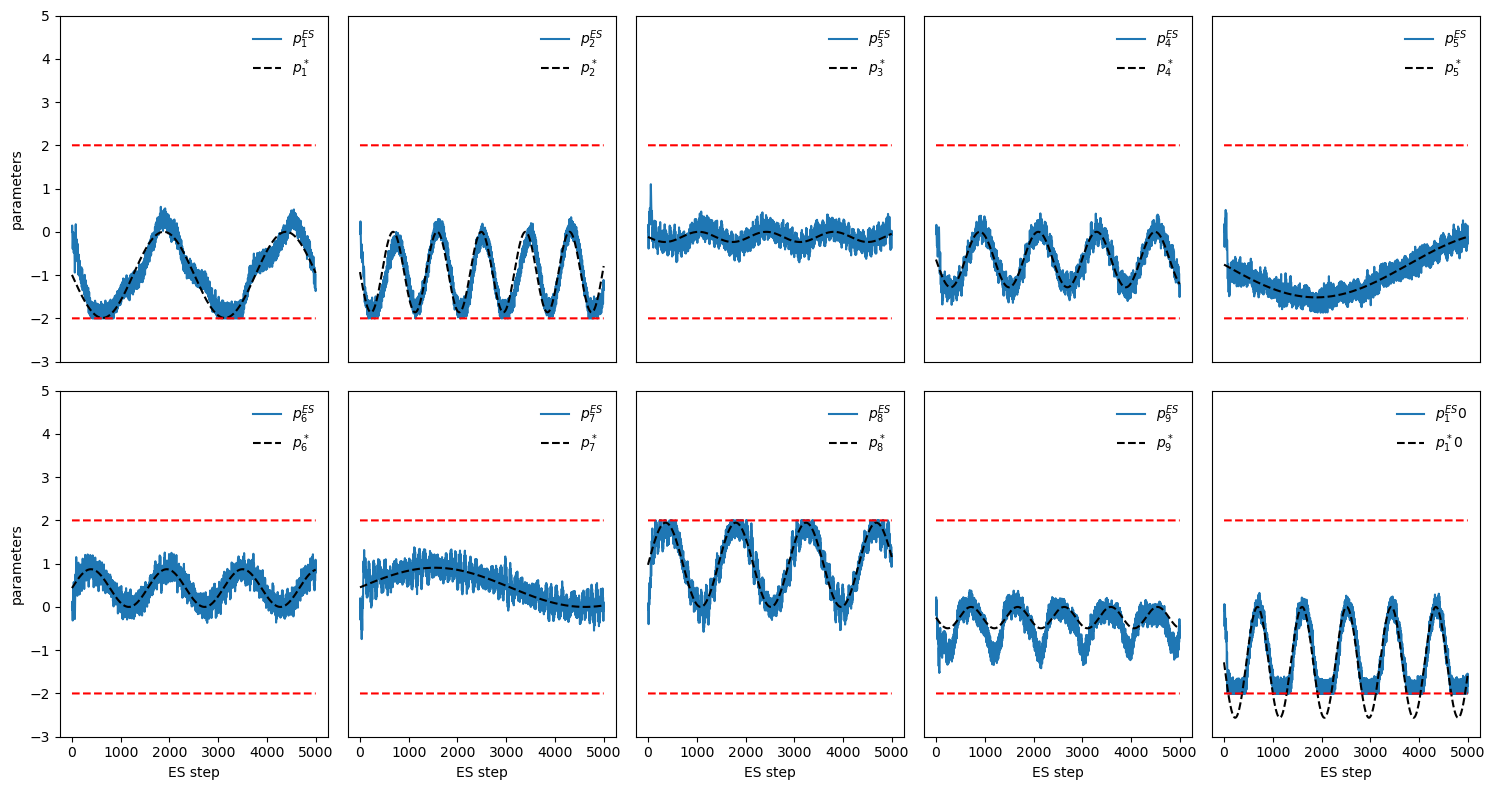

In [18]:
# Plot Individual Parameter Trajectories
plt.figure(2,figsize=(15,8))

for n in np.arange(nES):
    
    
    plt.subplot(2,5,n+1)
    plt.plot(X.data[f'p{n}'],label=f'$p^{{ES}}_{n+1}$')
    plt.plot(_p_opt[:,n],'k--',label=f'$p^*_{n+1}$')
    plt.plot(2+np.zeros(ES_steps),'r--')
    plt.plot(-2+np.zeros(ES_steps),'r--')
    plt.ylim([-3,5])
    plt.legend(frameon=False,loc=1)
    if n == 0:
        plt.ylabel('parameters')
    elif n == 5:
        plt.ylabel('parameters')
    else:
        plt.yticks([])
    if n > 4:
        plt.xlabel('ES step')
    else:
        plt.xticks([])

plt.tight_layout()